# DL11

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import LambdaLR
import torch.nn.init as init

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
tr=pd.read_csv('train.csv')
tst=pd.read_csv('test.csv')
sample=pd.read_csv('sample_submission.csv')

# 전처리

In [5]:
def avgLogTime (df):
    df['average_login_time']=round(df['average_login_time']).astype('int')
    df.loc[(df['average_login_time']<8), 'average_login_time']=8
    df.loc[(df['average_login_time']>22), 'average_login_time']=22
    
def avgTime4LS (df):
    df['average_time_per_learning_session']=round(df['average_time_per_learning_session']).astype('int')
    df.loc[(df['average_time_per_learning_session']>165), 'average_time_per_learning_session']=165
    df['aT4LS165']=0
    df.loc[(df['average_time_per_learning_session']==165), 'aT4LS165']=1
    return df
    
def split_payment(df):
    df['pay1'], df['pay2'], df['pay3']=0,0,0
    df.loc[(df['payment_pattern']>3), 'pay1']=1
    df.loc[(df['payment_pattern']%4 == 2) | (df['payment_pattern']%4 == 3), 'pay2'] = 1
    df.loc[(df['payment_pattern']%2 == 1), 'pay3'] = 1
    #df.drop('payment_pattern', axis=1, inplace=True)
    
def ColWeight (tr, col):
    values=np.sort(tr[col].unique())
    df = pd.DataFrame(values, columns=[col])
    df['weight']=0
    df = df.reset_index(drop=True)
    for val in values:
        df.loc[df[col] == val, 'weight'] = tr[tr[col]==val]['target'].mean()
    df.rename(columns={col: 'feature'}, inplace=True)

    return df

def change2Weight(df, List):
    for col in List:
        weightTable = ColWeight(tr, col)
        for row in range(len(weightTable)):
            df[col] = df[col].replace({weightTable.loc[row, 'feature']: weightTable.loc[row, 'weight']})
        
    return df

def oneHot (df, List):
    df = pd.get_dummies(df, columns=List)
    
    return df

#ColList=['subscription_duration', 'recent_login_time', 'average_login_time', 'average_time_per_learning_session', 'monthly_active_learning_days', 'total_completed_courses', 'abandoned_learning_sessions', 'community_engagement_level', 'customer_inquiry_history', 'payment_pattern']
ColList=['subscription_duration', 'recent_login_time', 'average_login_time', 'average_time_per_learning_session', 'monthly_active_learning_days', 'total_completed_courses', 'abandoned_learning_sessions', 'community_engagement_level', 'customer_inquiry_history', 'payment_pattern', 'preferred_difficulty_level', 'subscription_type']
#onehotList=['preferred_difficulty_level', 'subscription_type']
onehotList=[]

def preprocess1 (df):
    avgLogTime(df)
    df=avgTime4LS(df)
    
    return df
    
def preprocess2 (df):
    split_payment(df)
    df=change2Weight(df, ColList)
    oneHot(df, onehotList)
    df.drop(columns='recent_learning_achievement', inplace=True)
    
    return df

In [6]:
tst=preprocess1(tst)
tr=preprocess1(tr)

In [7]:
tst=preprocess2(tst)
tr=preprocess2(tr)

# Train, Validation

In [8]:
train, validation = train_test_split(tr, test_size=0.2, random_state=42)

In [9]:
# train 데이터와 validation 데이터를 numpy 배열로 생성
train_X = np.array(train.drop(['user_id', 'target'], axis=1))
train_y = np.array(train['target'])
validation_X = np.array(validation.drop(['user_id', 'target'], axis=1))
validation_y = np.array(validation['target'])

# PyTorch 텐서로 변환
train_X = torch.tensor(train_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.int64)
validation_X = torch.tensor(validation_X, dtype=torch.float32)
validation_y = torch.tensor(validation_y, dtype=torch.int64)

In [15]:
import torch.nn.init as init

# 모델 정의
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(16, 64)
        self.bn1 = nn.BatchNorm1d(64)  # 배치 정규화 레이어 추가
        #self.dropout1 = nn.Dropout(0.5)  # 첫 번째 Dropout 레이어 추가
        self.fc2 = nn.Linear(64, 64)
        self.bn2 = nn.BatchNorm1d(64)  # 배치 정규화 레이어 추가
        #self.dropout2 = nn.Dropout(0.5)  # 첫 번째 Dropout 레이어 추가
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)  # 배치 정규화 적용
        #x = self.dropout1(x)  # 첫 번째 Dropout 레이어 적용
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)  # 배치 정규화 적용
        #x = self.dropout2(x)  # 첫 번째 Dropout 레이어 적용
        x = self.fc3(x)
        x = torch.sigmoid(x)  # Sigmoid 활성화 함수 적용
        return x

model = BinaryClassifier()

# 하이퍼파라미터 설정
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)
num_epochs = 900

Epoch [90/900], Train Loss: 0.6731, Train Accuracy: 0.4557, Validation Loss: 0.6753, Validation Accuracy: 0.4570
Epoch [180/900], Train Loss: 0.6641, Train Accuracy: 0.4916, Validation Loss: 0.6686, Validation Accuracy: 0.4810
Epoch [270/900], Train Loss: 0.6569, Train Accuracy: 0.5148, Validation Loss: 0.6624, Validation Accuracy: 0.4980
Epoch [360/900], Train Loss: 0.6500, Train Accuracy: 0.5351, Validation Loss: 0.6565, Validation Accuracy: 0.5215
Epoch [450/900], Train Loss: 0.6432, Train Accuracy: 0.5586, Validation Loss: 0.6507, Validation Accuracy: 0.5455
Epoch [540/900], Train Loss: 0.6367, Train Accuracy: 0.5771, Validation Loss: 0.6452, Validation Accuracy: 0.5625
Epoch [630/900], Train Loss: 0.6310, Train Accuracy: 0.5929, Validation Loss: 0.6407, Validation Accuracy: 0.5765
Epoch [720/900], Train Loss: 0.6261, Train Accuracy: 0.6091, Validation Loss: 0.6373, Validation Accuracy: 0.5880
Epoch [810/900], Train Loss: 0.6219, Train Accuracy: 0.6251, Validation Loss: 0.6354, Val

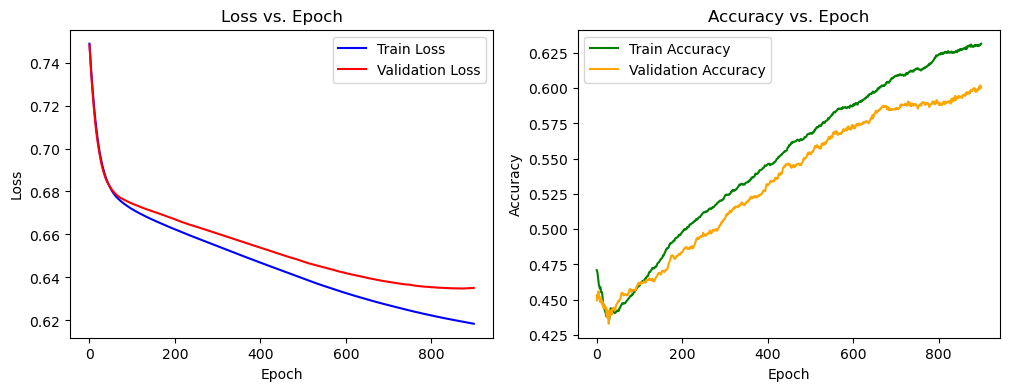

In [16]:
# 모델 학습
train_losses = []  # 훈련 손실 저장
train_accuracies = []  # 훈련 정확도 저장
validation_losses = []  # 검증 손실 저장
validation_accuracies = []  # 검증 정확도 저장

for epoch in range(num_epochs):
    # 훈련 데이터에 대한 forward 및 역전파
    optimizer.zero_grad()
    train_outputs = model(train_X)
    train_loss = criterion(train_outputs, train_y.float().view(-1, 1))
    train_loss.backward()
    optimizer.step()
    
    # 훈련 데이터 정확도 계산
    train_predicted = (train_outputs > 0.55).float()
    train_accuracy = accuracy_score(train_y, train_predicted)
    
    # 검증 데이터에 대한 forward
    with torch.no_grad():
        validation_outputs = model(validation_X)
        validation_loss = criterion(validation_outputs, validation_y.float().view(-1, 1))
    
    # 검증 데이터 정확도 계산
    validation_predicted = (validation_outputs > 0.55).float()
    validation_accuracy = accuracy_score(validation_y, validation_predicted)
    
    # 손실과 정확도 저장
    train_losses.append(train_loss.item())
    train_accuracies.append(train_accuracy)
    validation_losses.append(validation_loss.item())
    validation_accuracies.append(validation_accuracy)
    
    if (epoch + 1) % (num_epochs // 10) == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {validation_loss.item():.4f}, Validation Accuracy: {validation_accuracy:.4f}')

# 손실과 정확도 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(validation_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(validation_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()

# Retrain

In [17]:
X = np.array(tr.drop(['user_id', 'target'], axis=1))  # 'target' 열을 제외한 모든 열을 특성으로 사용
y = np.array(tr['target'])
X_test = np.array(tst.drop('user_id', axis=1))

# PyTorch 텐서로 변환
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)

In [18]:
import torch.nn.init as init

# 모델 정의
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(16, 64)
        self.bn1 = nn.BatchNorm1d(64)  # 배치 정규화 레이어 추가
        #self.dropout1 = nn.Dropout(0.5)  # 첫 번째 Dropout 레이어 추가
        self.fc2 = nn.Linear(64, 64)
        self.bn2 = nn.BatchNorm1d(64)  # 배치 정규화 레이어 추가
        #self.dropout2 = nn.Dropout(0.5)  # 첫 번째 Dropout 레이어 추가
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)  # 배치 정규화 적용
        #x = self.dropout1(x)  # 첫 번째 Dropout 레이어 적용
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)  # 배치 정규화 적용
        #x = self.dropout2(x)  # 첫 번째 Dropout 레이어 적용
        x = self.fc3(x)
        x = torch.sigmoid(x)  # Sigmoid 활성화 함수 적용
        return x

model = BinaryClassifier()

# 하이퍼파라미터 설정
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)
num_epochs = 900

Epoch [90/900], Loss: 0.6783, Accuracy: 0.4497
Epoch [180/900], Loss: 0.6667, Accuracy: 0.4828
Epoch [270/900], Loss: 0.6582, Accuracy: 0.5111
Epoch [360/900], Loss: 0.6509, Accuracy: 0.5330
Epoch [450/900], Loss: 0.6443, Accuracy: 0.5546
Epoch [540/900], Loss: 0.6384, Accuracy: 0.5732
Epoch [630/900], Loss: 0.6332, Accuracy: 0.5909
Epoch [720/900], Loss: 0.6287, Accuracy: 0.6055
Epoch [810/900], Loss: 0.6251, Accuracy: 0.6110
Epoch [900/900], Loss: 0.6224, Accuracy: 0.6181


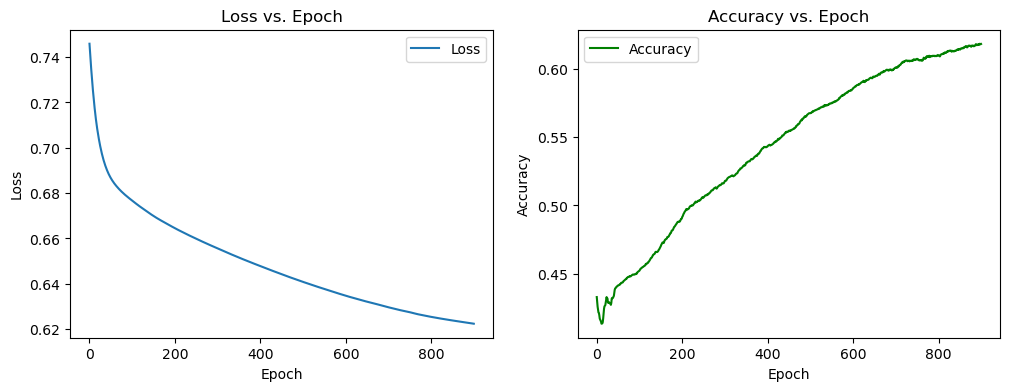

In [19]:
# 모델 학습
losses = []  # 손실 저장
accuracies = []  # 정확도 저장
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y.float().view(-1, 1))
    loss.backward()
    optimizer.step()
    
    # 정확도 계산
    predicted = (outputs > 0.55).float()
    accuracy = accuracy_score(y, predicted)
    
    losses.append(loss.item())
    accuracies.append(accuracy)
    
    if (epoch + 1) % (num_epochs // 10) == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

# 손실과 정확도 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()

# Prediction

In [27]:
# 모델을 평가 모드로 설정
model.eval()

# PyTorch 텐서로 변환
X_test = torch.tensor(X_test, dtype=torch.float32)

# 예측 생성
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = (y_pred >= 0.534).float()  # 임계값 0.5를 기준으로 이진 분류 결과 생성

# 제출 양식 파일(sample_submission.csv)의 'target' 컬럼에 나의 Test 데이터에 대한 예측 결과로 채우기
sub=sample.copy()
sub['target'] = y_pred

# 리더보드 제출을 위해 나의 예측 결과를 baseline_submit.csv로 저장
sub['target']=sub['target'].astype('int')

submit_path = 'submission/DL11.1.csv'
sub.to_csv(submit_path, index=False)

sub['target'].value_counts()

C:\Users\young0tete\AppData\Local\Temp\ipykernel_196832\2819717918.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


1    6192
0    3808
Name: target, dtype: int64

In [15]:
tr['target'].value_counts()

1    6199
0    3801
Name: target, dtype: int64